# Project: Easy Writer (Reflexion)

- [Reflexion](https://langchain-ai.github.io/langgraph/tutorials/reflexion/reflexion/)

## Defining the AgentState and the Prompts

In [19]:
%%capture
!pip install -U langsmith
!pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph
!pip install -q langgraph-checkpoint-sqlite
!pip install -q tavily-python

In [2]:
import os
import openai
import getpass

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OPENAI_API_KEY: ")
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LANGCHAIN_API_KEY: ")

Enter your OPENAI_API_KEY:  ········
Enter your LANGCHAIN_API_KEY:  ········


In [8]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your TAVILY_API_KEY: ")

Enter your TAVILY_API_KEY:  ········


In [4]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "pr-tracing-with-langsmith"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [5]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [6]:
from typing import TypedDict, List, Annotated

# Creating a class for the agent state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [9]:
# Defining the planning prompt 
PLAN_PROMPT = '''You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.'''

# defining the prompt that will be used by the agent that's doing research after the planning step
# given a plan, it will generate some queries and pass them to Tavily
RESEARCH_PLAN_PROMPT = '''You are a researcher charged with providing information that can be used when writing the following essay.
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

# Defining the writer prompt
WRITER_PROMPT = '''You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed: 

------

{content}'''

# Defining the reflection prompt
REFLECTION_PROMPT = '''You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc.'''

# Defining the research critique prompt
RESEARCH_CRITIQUE_PROMPT = ''''You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

In [10]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
# Importing and instantiating a tavily client
from tavily import TavilyClient

tavily = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])

## Implementing the Agents and the Nodes

In [12]:
# Creating the planning node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
# Creating the reseach_plan_node
# It generates research queries based on a given task and retrieves relevant content using those queries
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    # content = state['content'] or [] # fix - change to this:
    content = state.get('content', [])
    
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
# Creating the generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    
    response = model.invoke(messages)
     
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [15]:
# Creating the reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
# Creating the research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {'content': content}

## Defining the Conditional Edge

In [17]:
# Defining the conditional edge
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

## Defining the Graph

In [18]:
builder = StateGraph(AgentState)

# Adding nodes to the graph
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

# Setting the entry point of the state graph
builder.set_entry_point('planner')

# Adding the conditional edge
builder.add_conditional_edges(
    'generate', 
    should_continue, 
    {END: END, 'reflect': 'reflect'}
)

# Adding regular edges
builder.add_edge('planner', 'research_plan')
builder.add_edge('research_plan', 'generate')

builder.add_edge('reflect', 'research_critique')
builder.add_edge('research_critique', 'generate')

## Adding Memory

In [20]:
from langgraph.checkpoint.sqlite import SqliteSaver
# fix - import this
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

# graph = builder.compile(checkpointer=memory) # fix - change to this:
graph = builder.compile(checkpointer=MemorySaver())

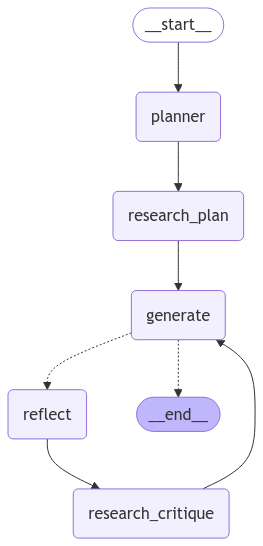

In [21]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


## Running the Agentic App

In [22]:
thread = {'configurable': {'thread_id': '1'}}
task = 'Nvidia  Blackwell AI chip'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': "**Outline for Essay on Nvidia Blackwell AI Chip**\n\n**I. Introduction**\n   A. Background on Nvidia as a leader in AI technology\n      1. Brief history of Nvidia's contributions to AI and computing\n      2. Overview of the importance of AI chips in modern technology\n   B. Introduction to the Blackwell AI chip\n      1. Definition and purpose of the Blackwell chip\n      2. Significance of the Blackwell chip in the context of AI advancements\n\n**II. Technical Specifications of the Blackwell AI Chip**\n   A. Architecture and design\n      1. Overview of the chip's architecture (e.g., GPU vs. CPU)\n      2. Innovations in design that enhance performance\n   B. Performance metrics\n      1. Processing power and speed\n      2. Energy efficiency and thermal management\n   C. Comparison with previous Nvidia chips (e.g., Ampere, Hopper)\n      1. Improvements and advancements in technology\n\n**III. Applications of the Blackwell AI Chip**\n   A. Use in machine learn

In [23]:
from IPython.display import Markdown, display

display(Markdown(e['generate']['draft']))

**NVIDIA Blackwell AI Chip: Revolutionizing the Future of Artificial Intelligence**

**I. Introduction**

NVIDIA Corporation has long been a pioneer in the realm of artificial intelligence (AI) and computing technology. Since its inception in 1993, the company has consistently pushed the boundaries of what is possible with graphics processing units (GPUs), evolving from gaming hardware to essential components in AI and deep learning applications. As AI continues to permeate various sectors, the demand for specialized AI chips has surged, making them critical to modern technological advancements. Among these innovations is the Blackwell AI chip, a next-generation GPU that promises to redefine the landscape of AI computing. This essay will explore the significance of the Blackwell chip, its technical specifications, applications, competitive landscape, and the challenges it faces in the evolving AI market.

**II. Technical Specifications of the Blackwell AI Chip**

The Blackwell AI chip is built upon a sophisticated architecture that distinguishes it from traditional CPUs. Unlike CPUs, which are designed for general-purpose tasks, the Blackwell chip is optimized for parallel processing, making it ideal for handling the complex computations required in AI applications. The architecture features NVIDIA's custom Tensor Core technology, which enhances performance for large language models and deep learning algorithms. With a processing power that boasts 30 times the speed of its predecessors, the Blackwell chip also emphasizes energy efficiency, achieving 25 times greater energy efficiency than previous models like the Hopper and Ampere. This is crucial for managing thermal output and ensuring sustained performance during intensive computational tasks.

**III. Applications of the Blackwell AI Chip**

The Blackwell AI chip is poised to make significant contributions to machine learning and deep learning. Its architecture supports advanced algorithms and models, such as Mixture-of-Experts (MoE) and large language models (LLMs), which are essential for applications ranging from natural language processing to image recognition. For instance, in the healthcare sector, the Blackwell chip can accelerate the analysis of medical images, leading to faster diagnoses and improved patient outcomes. Similarly, in the automotive industry, it can enhance the capabilities of autonomous vehicles by processing vast amounts of data in real-time. The potential for innovation and disruption across various industries is immense, as the Blackwell chip enables organizations to harness the power of AI more effectively.

**IV. Competitive Landscape**

In the competitive landscape of AI chips, NVIDIA's Blackwell faces challenges from other major players such as AMD, Intel, and Google. Each competitor offers unique strengths and weaknesses, with AMD focusing on high-performance computing and Intel leveraging its established market presence. However, the Blackwell chip's unparalleled performance metrics and energy efficiency provide NVIDIA with a strategic advantage. As the demand for AI hardware continues to grow, NVIDIA is well-positioned to lead the market, shaping the future of AI technology. Predictions suggest that the evolution of AI hardware will increasingly focus on scalability and integration, areas where NVIDIA's innovations, such as the NVLink technology, will play a crucial role.

**V. Challenges and Considerations**

Despite its promising capabilities, the development of the Blackwell AI chip is not without challenges. Technical hurdles related to scalability and integration must be addressed to meet the growing demand for more powerful chips. Additionally, ethical considerations surrounding AI technology are paramount. As AI systems become more integrated into society, the implications of their advancements must be carefully considered. NVIDIA has a responsibility to promote ethical AI use, ensuring that its technologies contribute positively to society while mitigating potential risks.

**VI. Conclusion**

In conclusion, the NVIDIA Blackwell AI chip represents a monumental leap in AI hardware capabilities, with the potential to revolutionize various industries. Its advanced architecture, impressive performance metrics, and applications in machine learning and deep learning underscore its significance in the AI landscape. As NVIDIA navigates the competitive market and addresses the challenges of AI chip development, the future outlook for both the Blackwell chip and the AI chip market remains bright. Ultimately, the impact of the Blackwell chip on technology and society will be profound, paving the way for innovations that enhance our lives and drive progress in the digital age.

In [24]:
thread = {'configurable': {'thread_id': '2'}}
task = 'AI, LLMs, AND RAG'

prompt = {
    'task': task,
    'max_revisions': 3,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '**Essay Outline: AI, LLMs, and RAG**\n\n**I. Introduction**\n   A. Definition of key terms\n      1. Artificial Intelligence (AI)\n      2. Large Language Models (LLMs)\n      3. Retrieval-Augmented Generation (RAG)\n   B. Importance of the topic in the current technological landscape\n   C. Thesis statement: This essay explores the interplay between AI, LLMs, and RAG, highlighting their individual roles, synergies, and implications for the future of information processing and generation.\n\n**II. Overview of Artificial Intelligence**\n   A. Brief history of AI development\n   B. Types of AI\n      1. Narrow AI vs. General AI\n      2. Machine Learning and Deep Learning\n   C. Current applications of AI in various fields (e.g., healthcare, finance, education)\n\n**III. Understanding Large Language Models (LLMs)**\n   A. Definition and characteristics of LLMs\n   B. How LLMs work\n      1. Training processes (data, algorithms)\n      2. Architecture (transformers, 

In [25]:
display(Markdown(e['generate']['draft']))

**AI, LLMs, and RAG: A Comprehensive Exploration**

**I. Introduction**

Artificial Intelligence (AI), Large Language Models (LLMs), and Retrieval-Augmented Generation (RAG) are pivotal concepts in the realm of modern technology. AI refers to the simulation of human intelligence processes by machines, particularly computer systems. LLMs are a subset of AI designed to understand and generate human-like text based on vast datasets. RAG, on the other hand, is an innovative approach that combines retrieval mechanisms with generative models to enhance the quality and relevance of AI-generated content. Understanding these terms is essential as they play a significant role in shaping the future of information processing and generation. This essay explores the interplay between AI, LLMs, and RAG, highlighting their individual roles, synergies, and implications for the future.

**II. Overview of Artificial Intelligence**

The development of AI has a rich history, dating back to the mid-20th century when pioneers like Alan Turing laid the groundwork for machine intelligence. AI can be categorized into two main types: Narrow AI, which is designed for specific tasks, and General AI, which aims to perform any intellectual task that a human can do. Within this framework, machine learning and deep learning have emerged as critical components, enabling systems to learn from data and improve over time. Today, AI applications span various fields, including healthcare, where it aids in diagnostics; finance, where it enhances fraud detection; and education, where it personalizes learning experiences. The versatility of AI underscores its importance in contemporary society.

**III. Understanding Large Language Models (LLMs)**

LLMs are sophisticated AI systems characterized by their ability to process and generate human-like text. They are trained on extensive datasets, often comprising billions of words, using advanced algorithms and architectures, particularly transformers and attention mechanisms. These models, such as GPT-3 and BERT, have revolutionized natural language processing by enabling machines to understand context, nuance, and intent in human language. However, despite their impressive capabilities, LLMs face limitations, including biases in training data and challenges in generating factually accurate information. Understanding these characteristics is crucial for leveraging LLMs effectively in various applications.

**IV. Introduction to Retrieval-Augmented Generation (RAG)**

RAG is an innovative approach that enhances the capabilities of LLMs by integrating retrieval mechanisms with generative processes. This technique allows models to access external knowledge bases in real-time, retrieving relevant information to inform their responses. The synergy between retrieval and generation improves the accuracy and contextual relevance of AI-generated content. RAG has found applications in various domains, including customer support, where it equips chatbots with up-to-date information, and content creation, where it aids in generating articles based on current events. By combining the strengths of retrieval and generation, RAG represents a significant advancement in AI technology.

**V. The Synergy Between AI, LLMs, and RAG**

The interplay between AI, LLMs, and RAG creates a powerful ecosystem for information processing. AI enhances LLM capabilities by providing the foundational algorithms and data structures necessary for effective language understanding. RAG further amplifies LLM performance by ensuring that generated content is grounded in real-world data, thereby increasing its reliability. Case studies from industries such as customer service and content creation illustrate the effectiveness of this synergy. For instance, companies utilizing RAG-powered chatbots have reported improved customer satisfaction due to the accuracy and relevance of responses, showcasing the transformative potential of these technologies.

**VI. Implications for the Future**

The future of AI, LLMs, and RAG holds immense promise, with potential advancements in technology that could further enhance their capabilities. However, ethical considerations must be at the forefront of this development. Issues such as bias in AI and LLMs, as well as the potential for misinformation in generated content, pose significant challenges. Addressing these concerns is crucial to ensure responsible AI development. Moreover, the future of human-AI collaboration will likely evolve, with AI systems becoming more integrated into daily life, necessitating a thoughtful approach to their design and implementation.

**VII. Conclusion**

In conclusion, the exploration of AI, LLMs, and RAG reveals a complex and interconnected landscape that is shaping the future of information processing and generation. By understanding the individual roles and synergies of these technologies, we can better appreciate their implications for society. As we move forward, it is essential to prioritize responsible development and further research in this field to harness the full potential of AI while addressing the ethical challenges it presents. The journey of AI, LLMs, and RAG is just beginning, and their impact on our world will undoubtedly be profound.

In [26]:
thread = {'configurable': {'thread_id': '3'}}
task = 'Fundamentals of Data Engineering with AWS'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '**Outline for Essay: Fundamentals of Data Engineering with AWS**\n\n**I. Introduction**\n   A. Definition of Data Engineering\n      1. Explanation of data engineering and its importance in the data lifecycle.\n      2. Overview of the role of data engineers in organizations.\n   B. Introduction to AWS (Amazon Web Services)\n      1. Brief overview of AWS and its significance in cloud computing.\n      2. Importance of AWS in data engineering practices.\n   C. Thesis Statement\n      1. The essay will explore the fundamental concepts of data engineering, the tools and services provided by AWS, and best practices for implementing data engineering solutions in the cloud.\n\n**II. Core Concepts of Data Engineering**\n   A. Data Collection\n      1. Overview of data sources (structured, semi-structured, unstructured).\n      2. Techniques for data ingestion (batch vs. real-time).\n   B. Data Storage\n      1. Types of data storage solutions (databases, data lakes, dat

In [27]:
display(Markdown(e['generate']['draft']))

**Fundamentals of Data Engineering with AWS**

**I. Introduction**

Data engineering is a critical discipline within the data lifecycle, focusing on the design, construction, and management of systems that collect, store, and process data. Data engineers play a vital role in organizations by ensuring that data is accessible, reliable, and usable for analysis and decision-making. As businesses increasingly rely on data-driven insights, the demand for skilled data engineers continues to grow. In this context, Amazon Web Services (AWS) emerges as a leading cloud computing platform, offering a suite of services that facilitate data engineering practices. This essay will explore the fundamental concepts of data engineering, the tools and services provided by AWS, and best practices for implementing data engineering solutions in the cloud.

**II. Core Concepts of Data Engineering**

At the heart of data engineering lies the process of data collection, which involves gathering data from various sources, including structured, semi-structured, and unstructured formats. Techniques for data ingestion can be categorized into batch processing, where data is collected at intervals, and real-time processing, which allows for immediate data capture and analysis. Once data is collected, it must be stored appropriately. Organizations can choose from various storage solutions, such as databases, data lakes, and data warehouses, depending on their specific use cases and requirements.

Data processing is another essential aspect of data engineering, encompassing methodologies like ETL (Extract, Transform, Load) and ELT (Extract, Load, Transform). ETL involves transforming data before loading it into a target system, while ELT allows for transformations to occur after loading, often resulting in faster processing times. Tools and frameworks such as Apache Spark and Apache Kafka are commonly used to facilitate these processes. Additionally, ensuring data quality and governance is crucial for maintaining data integrity and compliance with regulations, which can be achieved through various techniques and best practices.

**III. AWS Services for Data Engineering**

AWS provides a robust set of services tailored for data engineering tasks. For data ingestion, AWS Glue and Amazon Kinesis are prominent services that enable seamless data collection from diverse sources. AWS Glue automates the ETL process, while Amazon Kinesis allows for real-time data streaming, making it easier to handle large volumes of data efficiently.

When it comes to data storage, Amazon S3 (Simple Storage Service) serves as a popular choice for building data lakes, offering scalable and cost-effective storage solutions. For data warehousing, Amazon Redshift provides a powerful platform for analyzing large datasets. Each storage option has its unique advantages, and understanding these differences is essential for selecting the right solution for specific use cases.

Data processing tools on AWS include AWS Glue for ETL processes, Amazon EMR (Elastic MapReduce) for big data processing, and AWS Lambda for serverless data processing. These tools enable data engineers to build efficient and scalable data pipelines. Furthermore, AWS offers data analytics and visualization services, such as Amazon QuickSight for creating interactive dashboards and Amazon Athena for querying data stored in S3 using standard SQL.

**IV. Best Practices for Data Engineering on AWS**

To maximize the effectiveness of data engineering on AWS, several best practices should be followed. Scalability and performance optimization are paramount; designing data pipelines that can handle increasing data volumes is essential. Techniques such as partitioning and indexing can significantly enhance performance.

Cost management is another critical consideration, as AWS services can incur significant expenses if not monitored effectively. Implementing strategies to optimize resource usage, such as using spot instances or reserved instances, can help manage costs. Security and compliance are also vital, with best practices including data encryption, access controls, and adherence to regulations like GDPR and HIPAA.

Finally, continuous integration and deployment (CI/CD) practices are essential for maintaining efficient data engineering workflows. Utilizing tools like AWS CodePipeline and AWS CodeBuild can streamline the deployment process, ensuring that data pipelines are updated and maintained effectively.

**V. Conclusion**

In summary, data engineering is a foundational component of modern data-driven organizations, and AWS provides a comprehensive suite of services to support these efforts. By understanding core concepts such as data collection, storage, processing, and governance, data engineers can leverage AWS tools to build robust data solutions. As the field of data engineering continues to evolve, staying informed about emerging trends and technologies will be crucial for professionals in this space. Ultimately, the ability to adapt and learn continuously will empower data engineers to meet the challenges of an increasingly data-centric world.

In [28]:
thread = {'configurable': {'thread_id': '4'}}
task = 'Write an essay about Reflection vs. Reflexion in LangGraph.'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '### Essay Outline: Reflection vs. Reflexion in LangGraph\n\n#### I. Introduction\n   A. Definition of key terms: Reflection and Reflexion\n      1. Explanation of "Reflection" in programming and software development\n      2. Explanation of "Reflexion" in the context of LangGraph\n   B. Importance of understanding the distinction in the context of LangGraph\n   C. Thesis statement: While both Reflection and Reflexion serve critical roles in LangGraph, they differ fundamentally in their applications, implications, and outcomes.\n\n#### II. Overview of LangGraph\n   A. Brief introduction to LangGraph\n      1. Purpose and functionality of LangGraph\n      2. Importance in the field of programming languages and graph theory\n   B. Contextualizing Reflection and Reflexion within LangGraph\n      1. How LangGraph utilizes these concepts\n      2. The relevance of these concepts to users and developers\n\n#### III. Reflection in LangGraph\n   A. Definition and explanati

In [29]:
display(Markdown(e['generate']['draft']))

### Reflection vs. Reflexion in LangGraph

#### I. Introduction
In the realm of programming and software development, the terms "Reflection" and "Reflexion" hold significant importance, yet they represent distinct concepts. Reflection refers to the ability of a program to inspect and modify its own structure and behavior at runtime, a feature prevalent in many programming languages. On the other hand, Reflexion, as described by Shinn et al., is an architecture designed to facilitate learning through verbal feedback and self-reflection, particularly within the context of LangGraph. Understanding the distinction between these two concepts is crucial for developers and users of LangGraph, as it influences how they approach problem-solving and decision-making within the framework. This essay will explore the fundamental differences between Reflection and Reflexion in LangGraph, highlighting their applications, implications, and outcomes.

#### II. Overview of LangGraph
LangGraph is an innovative framework that integrates language models with graph structures, enabling the development of complex AI applications. Its primary purpose is to facilitate the creation of intelligent systems capable of understanding and reasoning through complex language inputs. Within LangGraph, both Reflection and Reflexion play vital roles. Reflection allows for dynamic code execution and metadata manipulation, while Reflexion enhances the system's ability to learn and adapt through feedback. By contextualizing these concepts within LangGraph, users and developers can better appreciate their relevance and utility in building sophisticated AI applications.

#### III. Reflection in LangGraph
Reflection in LangGraph refers to the mechanism that allows the framework to inspect and manipulate its own code and data structures at runtime. This capability enables developers to dynamically execute code, retrieve metadata, and modify objects without prior knowledge of their structure. For instance, a developer might use Reflection to access non-public members of a class or to create instances of classes dynamically based on user input. While Reflection offers significant flexibility and power, it also comes with drawbacks, such as performance overhead and potential security vulnerabilities. Developers must weigh these advantages and disadvantages when deciding to implement Reflection in their applications.

#### IV. Reflexion in LangGraph
In contrast, Reflexion focuses on the architecture of learning through feedback and self-reflection. It allows the system to analyze and visualize relationships within data, enhancing user interaction and experience. Reflexion is implemented in LangGraph by enabling the actor agent to critique its responses based on external data, fostering a deeper understanding of the information at hand. The applications of Reflexion include improving clarity in data structures and facilitating collaborative learning experiences. However, it may face limitations in terms of complexity and scalability, as the system's ability to process and reflect on vast amounts of data can be challenging.

#### V. Comparative Analysis
The key differences between Reflection and Reflexion lie in their purpose and functionality. Reflection is primarily concerned with dynamic code execution and manipulation, while Reflexion emphasizes learning and understanding through feedback. In terms of performance and usability, Reflection can introduce overhead, whereas Reflexion may struggle with scalability in complex scenarios. Developers should consider situational use cases for each concept; Reflection is ideal for tasks requiring dynamic code manipulation, while Reflexion is best suited for applications focused on user interaction and data analysis. The interplay between Reflection and Reflexion in LangGraph is essential, as they complement each other in creating a robust framework for intelligent systems, though challenges may arise in their integration.

#### VI. Conclusion
Understanding the distinction between Reflection and Reflexion in LangGraph is vital for developers and users alike. Each concept serves a unique purpose, contributing to the framework's overall functionality and effectiveness. As AI applications continue to evolve, the implications of these concepts will become increasingly significant. Developers are encouraged to explore and deepen their understanding of Reflection and Reflexion within LangGraph, as doing so will enhance their ability to create intelligent systems that can learn, adapt, and thrive in complex environments. By embracing these concepts, the potential for innovation in AI applications is boundless.